In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters

In [ ]:
epochs = 8000
batch = 16
eta = 0.001
weight_decay = 6e-8
imageShape = (224, 224, 1)
maskShape = (224, 224, 1)


#Data Pre-processing

In [ ]:
from google.colab import drive , files

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
directory_path = "/content/drive/MyDrive/ToothSegmentation"
zip_path = "/content/images.zip"

!zip -r {zip_file_path}{directory_path}



zip error: Nothing to do! ({zip_file_path}{directory_path}.zip)


In [ ]:
import os

def prepare_dataset(dataset_dir, split_ratio=0.8):
    image_dir = os.path.join(dataset_dir, "images")
    mask_dir = os.path.join(dataset_dir, "mask")

    image_filenames = os.listdir(image_dir)
    mask_filenames = os.listdir(mask_dir)

    return image_filenames, mask_filenames

dataset_dir = '/content/drive/MyDrive/ToothPics'

# Retrieve image and mask filenames
image_filenames, mask_filenames = prepare_dataset(dataset_dir)



In [ ]:
image_fn = natsort.natsorted(list(pathlib.Path("/content/drive/MyDrive/ToothPics/images").glob('*.*')))
mask_fn = natsort.natsorted(list(pathlib.Path("/content/drive/MyDrive/ToothPics/mask").glob('*.*')))


print(image_fn)
print(mask_fn)

[PosixPath('/content/drive/MyDrive/ToothPics/images/1.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/2.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/3.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/4.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/5.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/6.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/7.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/8.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/9.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/10.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/11.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/12.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/13.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/14.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/15.png'), PosixPath('/content/drive/MyDrive/ToothPics/images/16.png'), PosixPath('/content/drive/MyDriv

In [ ]:
class readDataset:
    def __init__(self, imagesPaths, masksPaths):
        self.imagePaths = '/content/drive/MyDrive/ToothPics/images'
        self.maskPaths = '/content/drive/MyDrive/ToothPics/mask'

    def readPaths(self):
        self.images =image_fn
        self.masks = mask_fn

    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, (224, 224))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)

    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
            for aug in range(2):
                imageup = image
                maskup = mask
                if aug == 0:
                    imageup = image
                    maskup = mask
                else:
                    imageup = tf.image.flip_left_right(imageup)
                    maskup = tf.image.flip_left_right(maskup)
                imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

# Define the directory paths

images_dir = '/content/drive/MyDrive/Toothpics/images'
masks_dir = '/content/drive/MyDrive/Toothpics/mask'

dobj = readDataset(images_dir , masks_dir)

dobj.readPaths()

images = dobj.readImages(dobj.images , "i")
masks = dobj.readImages(dobj.masks , "m")


In [ ]:
images.shape , masks.shape

((598, 224, 224), (598, 224, 224))

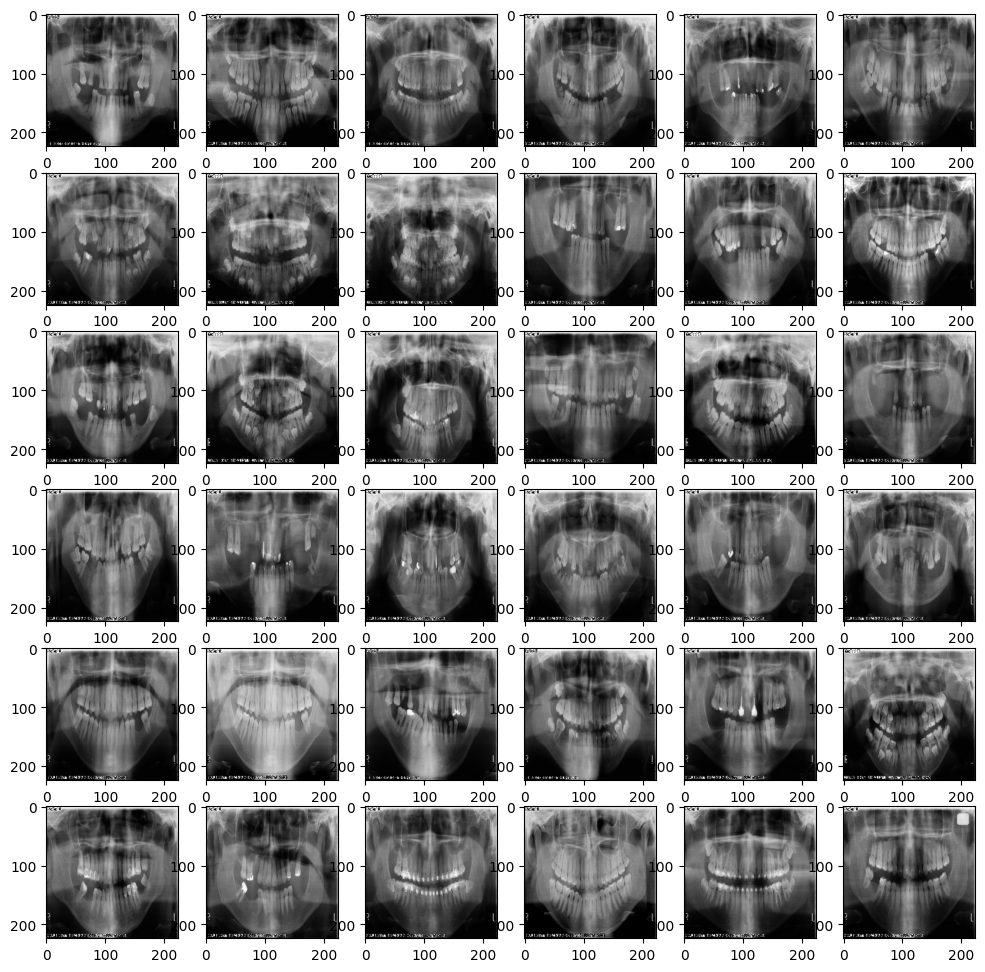

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')

plt.legend()

# With masks

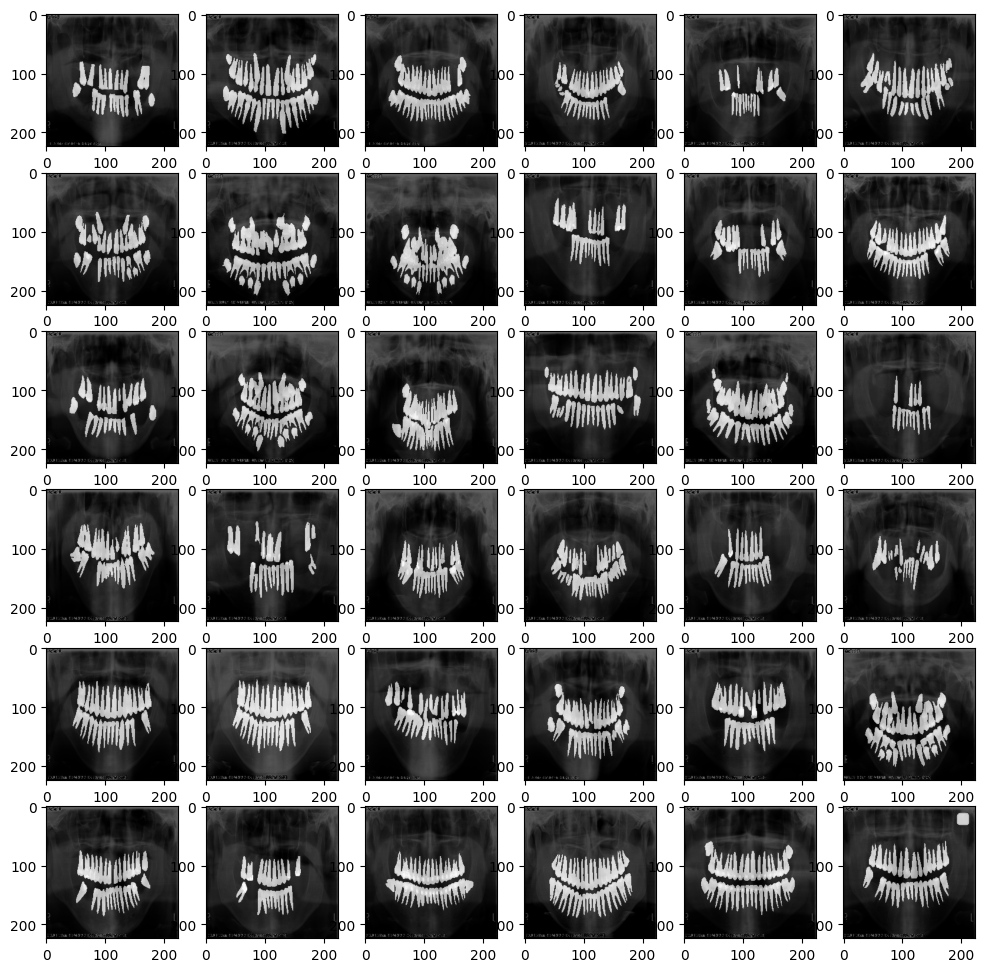

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [ ]:
i = 110
validImages = images[:i]
validMasks = masks[:i]
trainImages = images[i:]
trainMasks = masks[i:]
validImages.shape, validMasks.shape, trainImages.shape, trainMasks.shape

((110, 224, 224), (110, 224, 224), (488, 224, 224), (488, 224, 224))

# Model

    """
    Applies convolution operation based on the specified type.

    Args:
        inputs: Input tensor.x
        filters: Number of filters for the convolutional layers.
        padding: Padding mode.
        strides: Stride for the convolution operation.
        kernel_size: Kernel size for the convolutional layers.
        activation: Activation function.
        conv_type: Type of convolution operation ('encoder' or 'decoder').

    Returns:
        Output tensor after convolution.
    
    Encoder->
    conv2d
    group norm => stabilize training process
    we take layers.avg so low lvl features combined with high-level in a u-net style
    Acitvation Function
    """

In [ ]:
def convolution(inputs, filter, padding, strides, kernel, activation, conv_type):
  x = inputs
  x = layers.Conv2D(filter, kernel_size = kernel, padding = padding,
                    strides = strides)(x)
  x = layers.GroupNormalization(groups = filter)(x)
  if conv_type == 'decoder':
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter*2, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter*2)(x)
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter)(x)
  x = layers.average([x, layers.Conv2D(filter, kernel_size = 1, padding = 'same',
                                      strides = 1)(inputs)])
  x = layers.Activation(activation)(x)
  return x

In [ ]:
def encoder(input, filter, padding, strides, kernel, activation):
  #Takes the input image , and applies convolution to make it into a lower dimensional feature representation
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, 'encoder')
  #Downsample try -> maxPooling vs strided convolutions
  downsample = layers.AveragePooling2D()(x)
  return downsample, x

def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  #Upsampling done using 2dTranspose
  x = layers.Conv2DTranspose(filter, kernel_size = kernel, padding = padding,
                             strides = 2, activation = activation)(x)
  #Skip connection to bypass info , makes it faster
  x = layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, 'decoder')
  return x


In [ ]:
def generator(input, filter, padding, strides, kernel, weights):
  x = input
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = 'LeakyReLU')

  #Upsampling
  deco = decoder(con5, filter*16, skip5, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco1 = decoder(deco, filter*8, skip4, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco2 = decoder(deco1, filter*4, skip3, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco3 = decoder(deco2, filter*2, skip2, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco4 = decoder(deco3, filter, skip1, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')

                                                                                 #Upsample to desired size to match desired channel and size
  output = layers.Conv2DTranspose(1, kernel_size = kernel, strides = strides,
                                  padding = padding, activation = 'sigmoid')(deco4)

  generator = models.Model(inputs = input, outputs = output, name = 'generator')



  generator.summary()
  return generator

In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = None)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         320       ['input_1[0][0]']             
                                                                                                  
 group_normalization (Group  (None, 224, 224, 32)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         64        ['input_1[0][0]']     

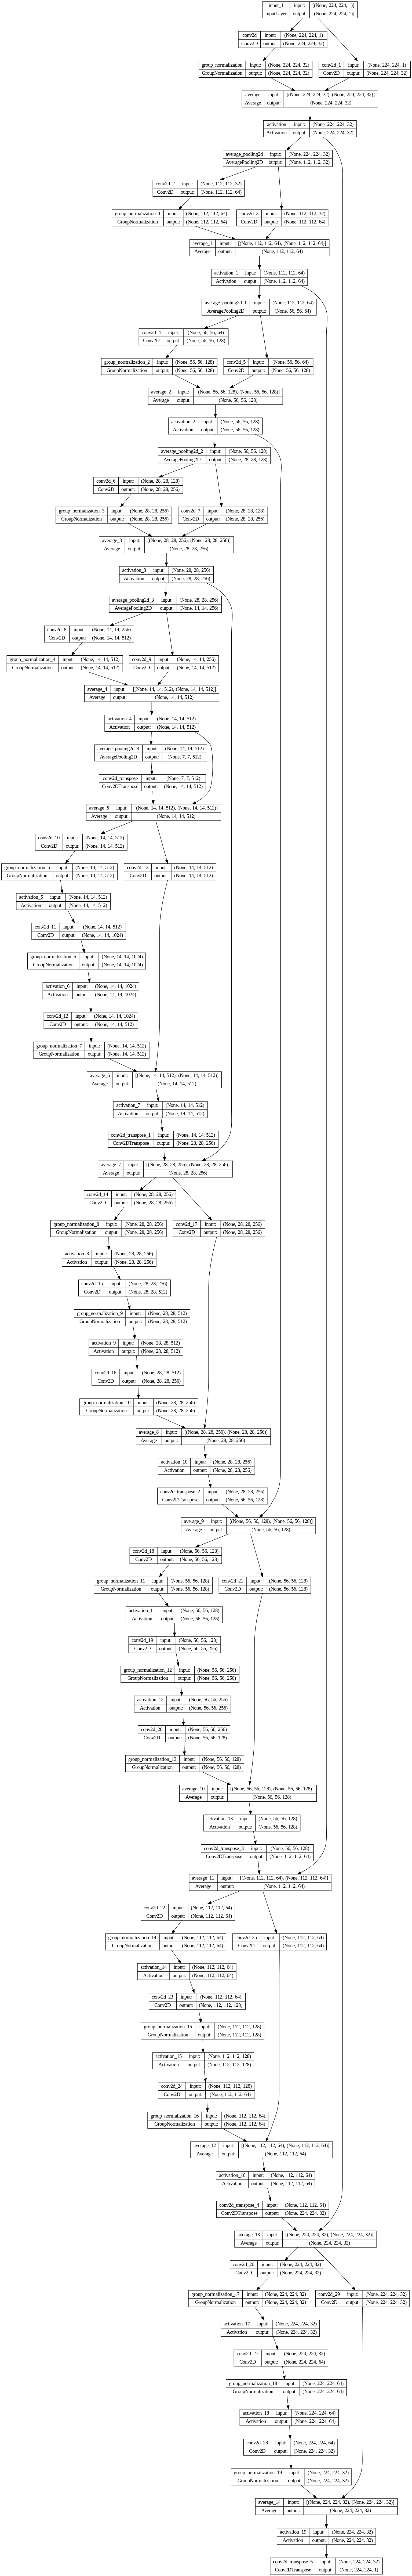

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(G, to_file='generator.png', show_shapes=True, show_layer_names=True)


In [ ]:
  def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, weights,
                    lossFn, learning_rate, weight_decay):
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                          kernel = kernel, activation = 'LeakyReLU')
    con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                          kernel = kernel, activation = 'LeakyReLU')
    con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                          kernel = kernel, activation = 'LeakyReLU')
    con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                          kernel = kernel, activation = 'LeakyReLU')
    con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                          kernel = kernel, activation = 'LeakyReLU')

    #1D tensor of avg values of all activations in that channel
    x = layers.GlobalAveragePooling2D()(con5)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs = [maskInput, ImageInput], outputs = x,
                                name = 'discriminator')

    discriminator.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                                                weight_decay = weight_decay))
    discriminator.summary()
    return discriminator

In [ ]:
D = discriminator(ImageInput = layers.Input(shape = imageShape), maskInput = layers.Input(shape = maskShape),
                  filter = 32, padding = 'same', strides = 1, kernel = 3, weights = None,
                  lossFn = 'mse', learning_rate = eta, weight_decay = weight_decay)


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 224, 224, 32)         320       ['multiply[0][0]']

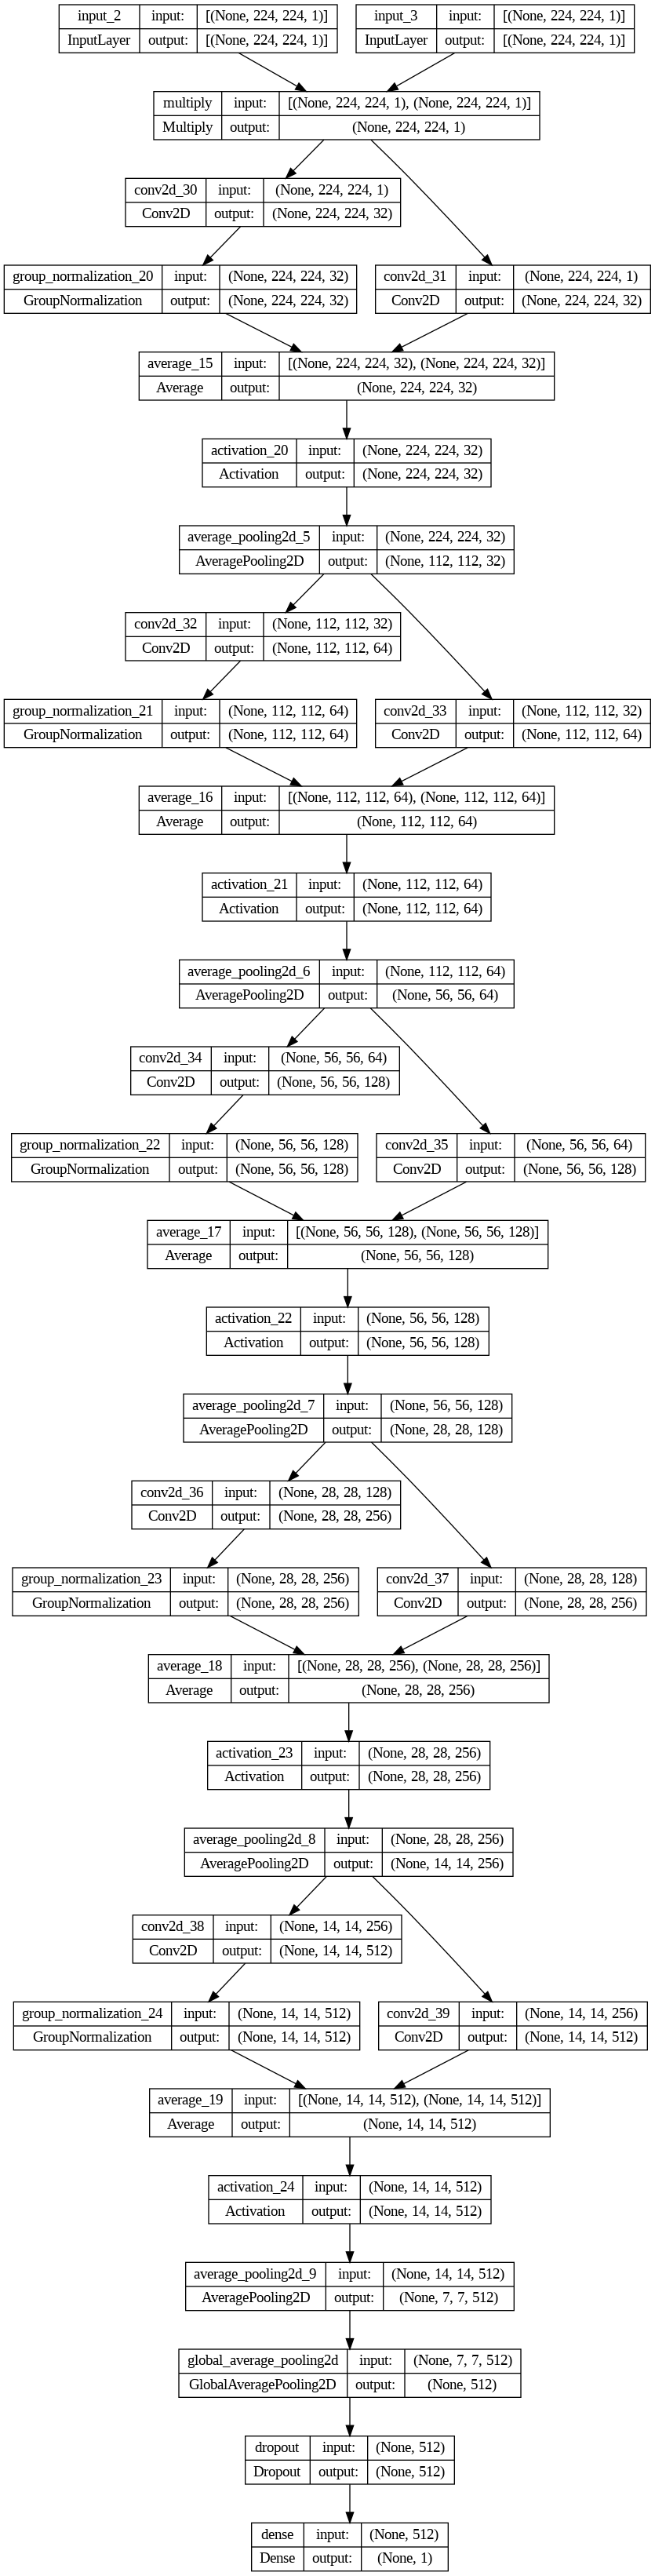

In [ ]:
plot_model(D, to_file='Discriminator.png', show_shapes=True, show_layer_names=True)


# GAN Training
Loss Func = MSE
Optimizer = RMSProp


In [ ]:
def GAN(discriminator, generator, imageInput, maskInput, learning_rate, weight_decay,
                   lossFn):
  discriminator.trainable = False
  gan = models.Model(
      inputs = [imageInput],
      outputs = discriminator([generator(imageInput), imageInput],),
      name = 'gan'
  )
  gan.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate*0.5,
                                                                              weight_decay = weight_decay*0.5))
  gan.summary()
  return gan

In [ ]:
gan = GAN(discriminator = D, generator = G, imageInput = layers.Input(shape = imageShape),
          maskInput = layers.Input(shape = maskShape), learning_rate = eta, weight_decay = weight_decay,
                   lossFn = 'mse')

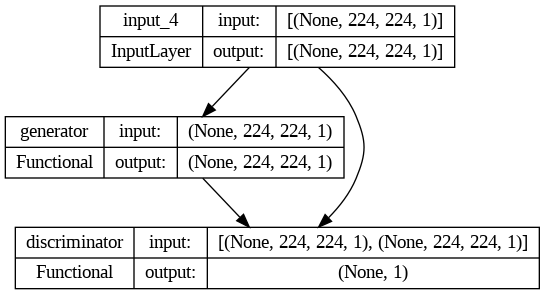

In [ ]:
tf.keras.utils.plot_model(gan, show_shapes = True)


In [ ]:
#Func to plot generated iamges and real masks
def samples(generator, images, realMasks):
  masks = tf.squeeze(generator.predict(images))
  all = np.vstack([realMasks, masks])
  plt.figure(figsize = (12, 4))
  for i in range(16):
    plt.subplot(2, 8, (i + 1))
    plt.imshow(all[i], cmap = 'gray')
  plt.show()

  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch/Epochs: 0/8000
discriminator loss: [tag: 0.5562039017677307,], generator loss: [tag: 0.10239952802658081,]
1/1 [==============================] - 7s 7s/step


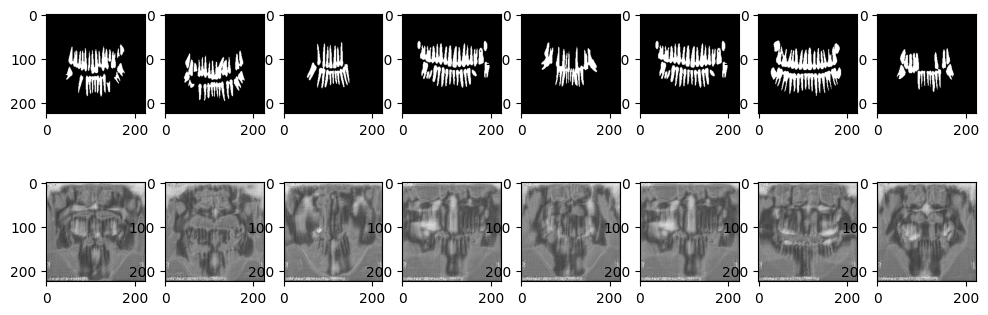

  6%|▋         | 500/8000 [11:44<2:27:52,  1.18s/it]

Epoch/Epochs: 500/8000
discriminator loss: [tag: 0.21271495521068573,], generator loss: [tag: 0.3471616506576538,]
1/1 [==============================] - 0s 26ms/step


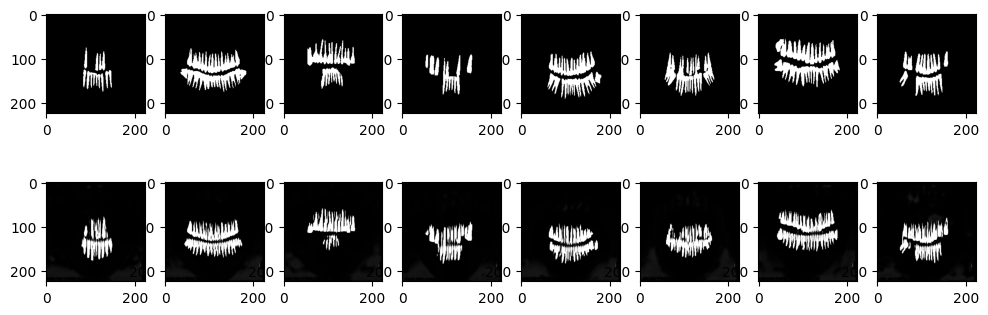

 12%|█▎        | 1000/8000 [21:45<2:17:27,  1.18s/it]

Epoch/Epochs: 1000/8000
discriminator loss: [tag: 0.2412814348936081,], generator loss: [tag: 0.2727508842945099,]
1/1 [==============================] - 0s 27ms/step


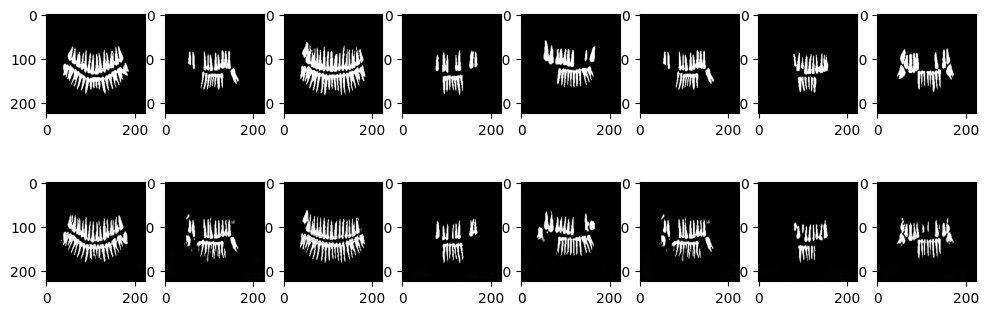

 19%|█▉        | 1500/8000 [31:45<2:05:51,  1.16s/it]

Epoch/Epochs: 1500/8000
discriminator loss: [tag: 0.24774639308452606,], generator loss: [tag: 0.20028263330459595,]
1/1 [==============================] - 0s 26ms/step


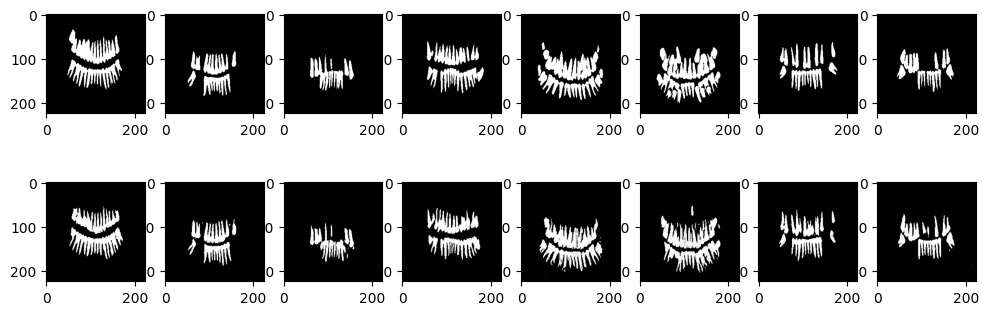

 25%|██▌       | 2000/8000 [41:47<2:00:01,  1.20s/it]

Epoch/Epochs: 2000/8000
discriminator loss: [tag: 0.27890607714653015,], generator loss: [tag: 0.12454355508089066,]
1/1 [==============================] - 0s 25ms/step


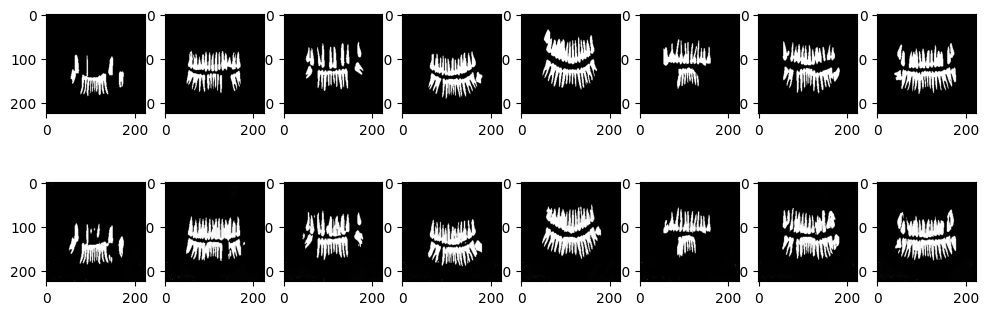

 31%|███▏      | 2500/8000 [51:53<1:49:28,  1.19s/it]

Epoch/Epochs: 2500/8000
discriminator loss: [tag: 0.27138081192970276,], generator loss: [tag: 0.5068981647491455,]
1/1 [==============================] - 0s 26ms/step


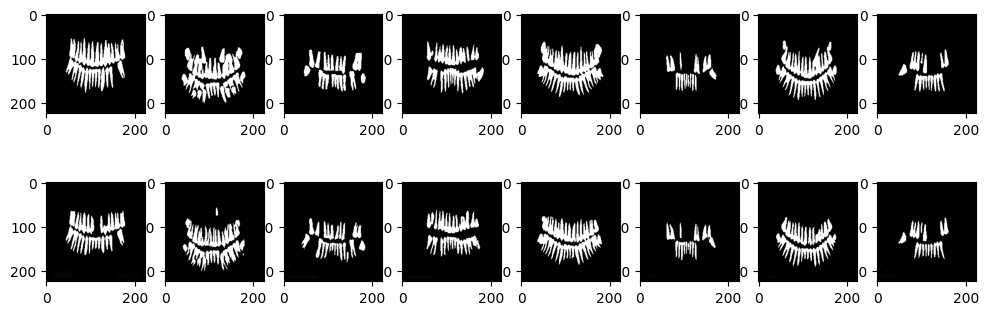

 38%|███▊      | 3000/8000 [1:02:01<1:37:53,  1.17s/it]

Epoch/Epochs: 3000/8000
discriminator loss: [tag: 0.24408681690692902,], generator loss: [tag: 0.7035937905311584,]
1/1 [==============================] - 0s 39ms/step


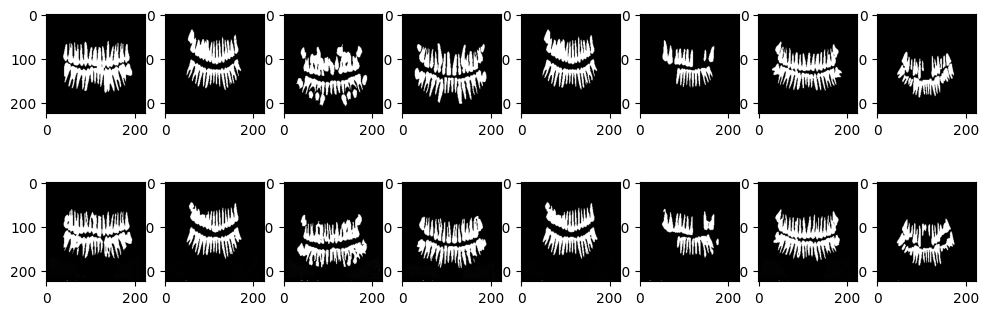

 44%|████▍     | 3500/8000 [1:11:50<1:25:05,  1.13s/it]

Epoch/Epochs: 3500/8000
discriminator loss: [tag: 0.13004307448863983,], generator loss: [tag: 0.3547914922237396,]
1/1 [==============================] - 0s 27ms/step


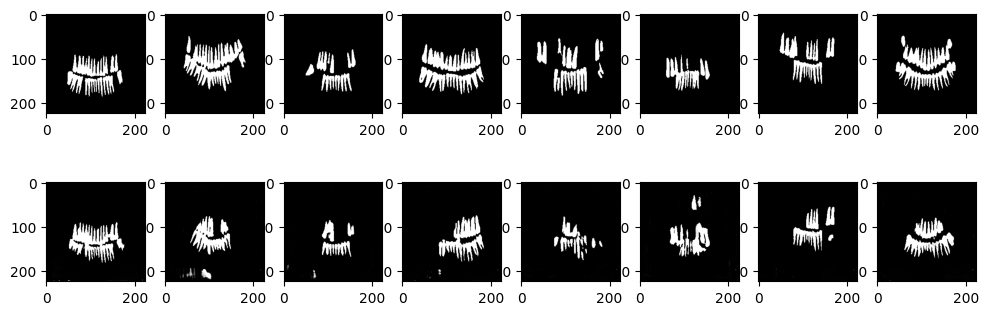

 50%|█████     | 4000/8000 [1:21:39<1:20:44,  1.21s/it]

Epoch/Epochs: 4000/8000
discriminator loss: [tag: 0.16822582483291626,], generator loss: [tag: 0.6762129068374634,]
1/1 [==============================] - 0s 26ms/step


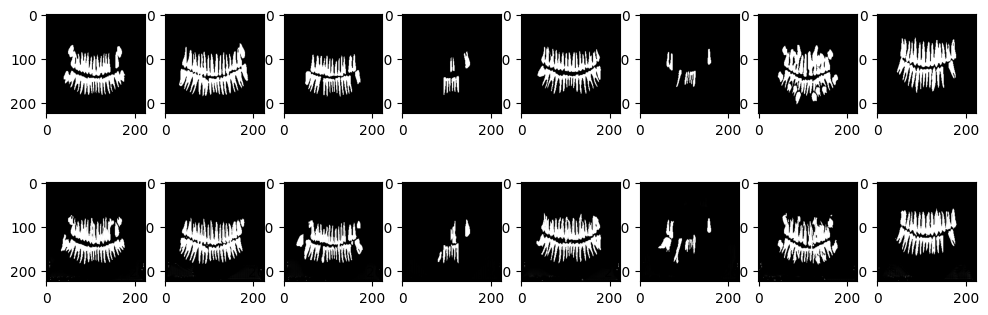

 56%|█████▋    | 4500/8000 [1:31:49<1:13:38,  1.26s/it]

Epoch/Epochs: 4500/8000
discriminator loss: [tag: 0.14155195653438568,], generator loss: [tag: 0.7468768358230591,]
1/1 [==============================] - 0s 25ms/step


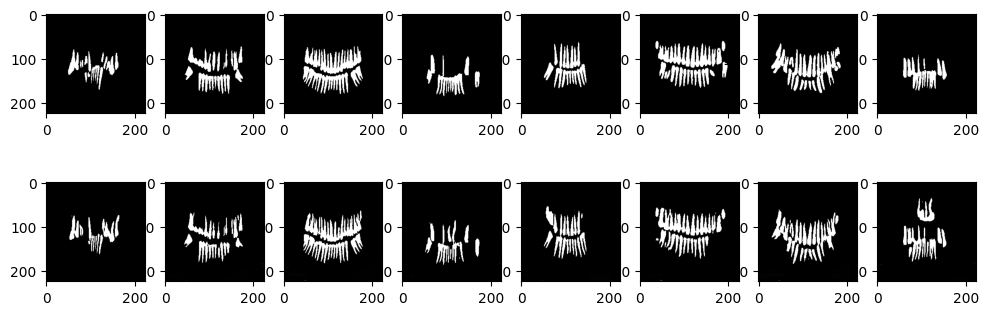

 62%|██████▎   | 5000/8000 [1:41:53<59:29,  1.19s/it]  

Epoch/Epochs: 5000/8000
discriminator loss: [tag: 0.15320654213428497,], generator loss: [tag: 0.6482019424438477,]
1/1 [==============================] - 0s 24ms/step


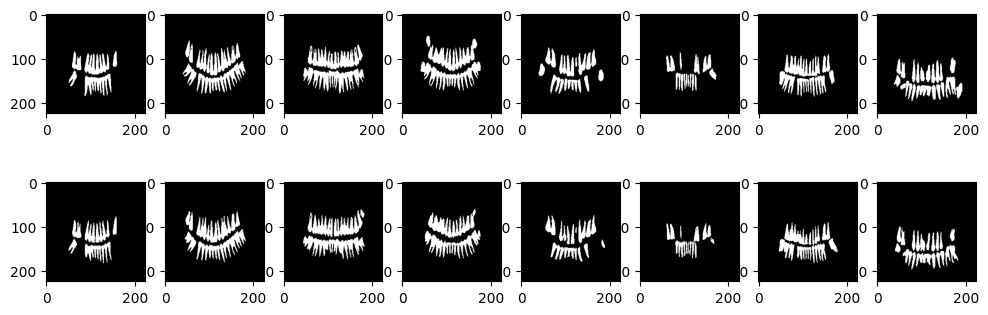

 69%|██████▉   | 5500/8000 [1:52:00<48:03,  1.15s/it]

Epoch/Epochs: 5500/8000
discriminator loss: [tag: 0.07968346774578094,], generator loss: [tag: 0.9350731372833252,]
1/1 [==============================] - 0s 30ms/step


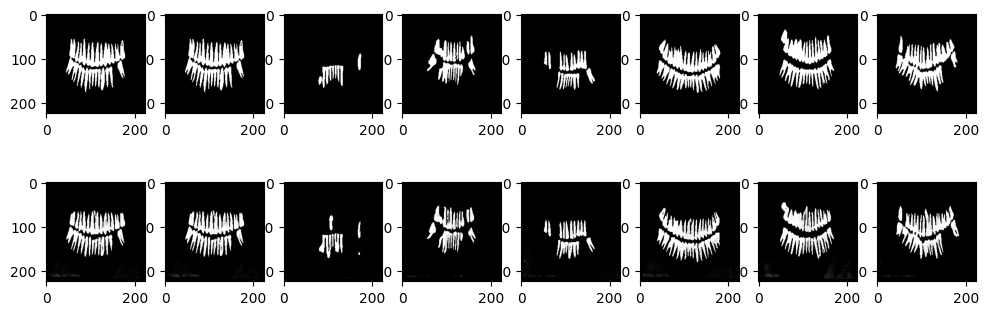

 75%|███████▌  | 6000/8000 [2:02:02<38:44,  1.16s/it]

Epoch/Epochs: 6000/8000
discriminator loss: [tag: 0.20324061810970306,], generator loss: [tag: 1.2177283763885498,]
1/1 [==============================] - 0s 38ms/step


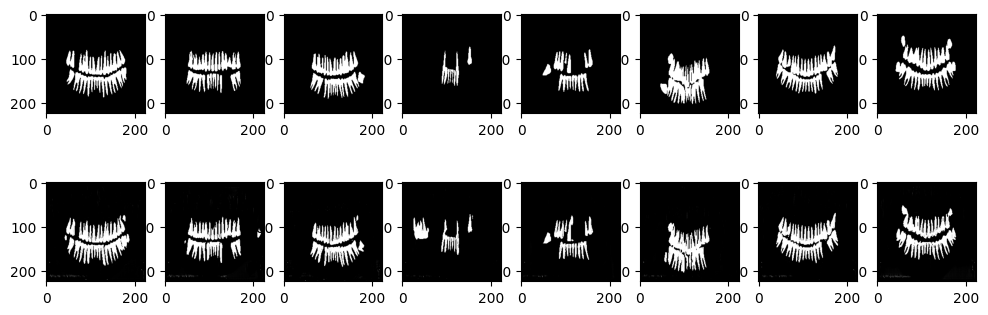

 81%|████████▏ | 6500/8000 [2:12:09<30:34,  1.22s/it]

Epoch/Epochs: 6500/8000
discriminator loss: [tag: 0.17143914103507996,], generator loss: [tag: 0.28600063920021057,]
1/1 [==============================] - 0s 25ms/step


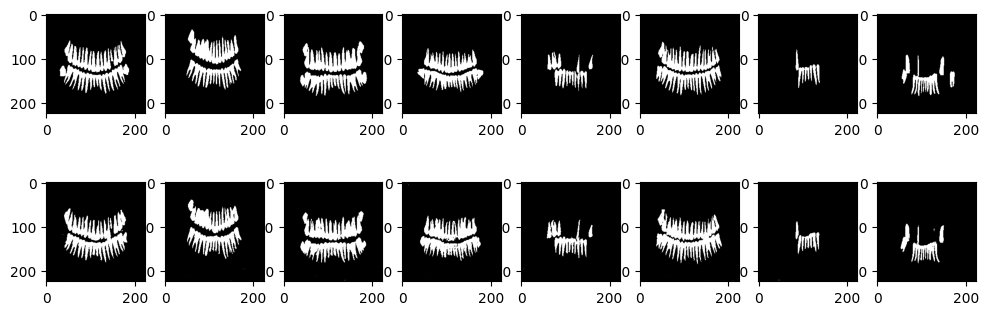

 88%|████████▊ | 7000/8000 [2:22:12<20:08,  1.21s/it]

Epoch/Epochs: 7000/8000
discriminator loss: [tag: 0.10118162631988525,], generator loss: [tag: 0.38249439001083374,]
1/1 [==============================] - 0s 24ms/step


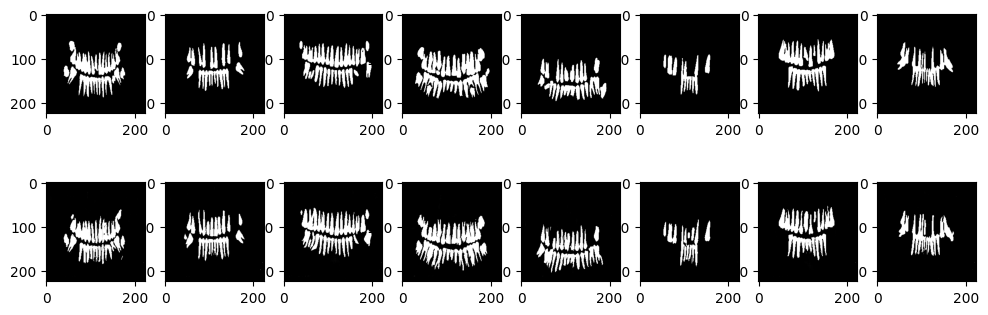

 94%|█████████▍| 7500/8000 [2:32:16<09:45,  1.17s/it]

Epoch/Epochs: 7500/8000
discriminator loss: [tag: 0.09839654713869095,], generator loss: [tag: 0.46926894783973694,]
1/1 [==============================] - 0s 26ms/step


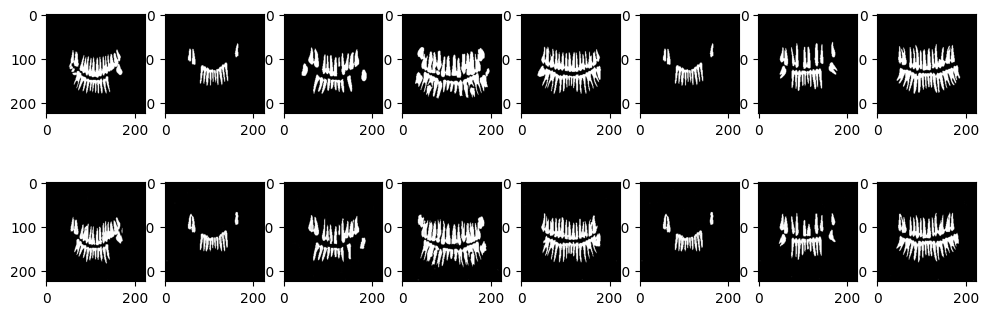

100%|██████████| 8000/8000 [2:42:24<00:00,  1.22s/it]


In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(epochs)):
    indexs = np.random.randint(0, len(trainImages), size=(batch,))

    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape=(batch,))
    #Generator creates fake masks
    fakeMasks = tf.squeeze(G.predict([realImages], verbose=0))
    fakeTag = tf.zeros(shape=(batch,))

    allMasks = np.vstack([realMasks, fakeMasks])
    allTags = np.hstack([realTag, fakeTag])

    allImages = np.vstack([realImages, realImages])
    #Calc loss
    dlossTag = D.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realImages], [realTag,])

    if epoch % 500 == 0:
        print('Epoch/Epochs: {}/{}'.format(epoch, epochs))
        print('discriminator loss: [tag: {},], generator loss: [tag: {},]'.format(dlossTag, glossTag))
        validIndexs = np.random.randint(0, len(validImages), size=(8,))
        samples(G, validImages[validIndexs], validMasks[validIndexs])
        #G.save_weights("/content/drive/MyDrive/ToothSegmentation/")
        #D.save_weights("/content/drive/MyDrive/ToothSegmentation/")


In [ ]:
G.save_weights("/content/drive/MyDrive/ToothGan/mask_gen.h5")
D.save_weights('/content/drive/MyDrive/ToothGan/mask_disc.h5')
#TO load the model afterwards
#G = tf.keras.models.load_model('/content/drive/MyDrive/ToothGan/mask_gen.h5')

In [ ]:
from tensorflow.keras.models import load_model


G.load_weights("/content/drive/MyDrive/ToothGan/mask_gen.h5")

#losddd
D.load_weights("/content/drive/MyDrive/ToothGan/mask_disc.h5")


In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = True)
for layer in G.layers[:20]:
  layer.trainable = False
G.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall')])

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 224, 224, 32)         320       ['input_4[0][0]']             
                                                                                                  
 group_normalization_25 (Gr  (None, 224, 224, 32)         64        ['conv2d_40[0][0]']           
 oupNormalization)                                                                                
                                                                                                  
 conv2d_41 (Conv2D)          (None, 224, 224, 32)         64        ['input_4[0][0]']     

In [ ]:
history = G.fit(trainImages, trainMasks, epochs = 160, batch_size = 8,
                        validation_data = (validImages, validMasks), callbacks = [
                            tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss',
                                                             mode = 'min',
                                                             restore_best_weights = True)
                        ])

Epoch 1/160
61/61 [==============================] - 77s 492ms/step - loss: 0.2480 - accuracy: 0.3057 - precision: 0.1266 - recall: 0.8512 - val_loss: 0.2174 - val_accuracy: 0.3644 - val_precision: 0.1366 - val_recall: 0.8687
Epoch 2/160
61/61 [==============================] - 19s 319ms/step - loss: 0.1967 - accuracy: 0.4551 - precision: 0.1561 - recall: 0.8459 - val_loss: 0.1779 - val_accuracy: 0.5539 - val_precision: 0.1755 - val_recall: 0.7966
Epoch 3/160
61/61 [==============================] - 20s 322ms/step - loss: 0.1645 - accuracy: 0.6414 - precision: 0.2030 - recall: 0.7214 - val_loss: 0.1519 - val_accuracy: 0.7266 - val_precision: 0.2345 - val_recall: 0.6268
Epoch 4/160
61/61 [==============================] - 20s 325ms/step - loss: 0.1427 - accuracy: 0.7734 - precision: 0.2687 - recall: 0.5610 - val_loss: 0.1338 - val_accuracy: 0.8196 - val_precision: 0.3060 - val_recall: 0.4703
Epoch 5/160
61/61 [==============================] - 19s 316ms/step - loss: 0.1277 - accuracy: 0

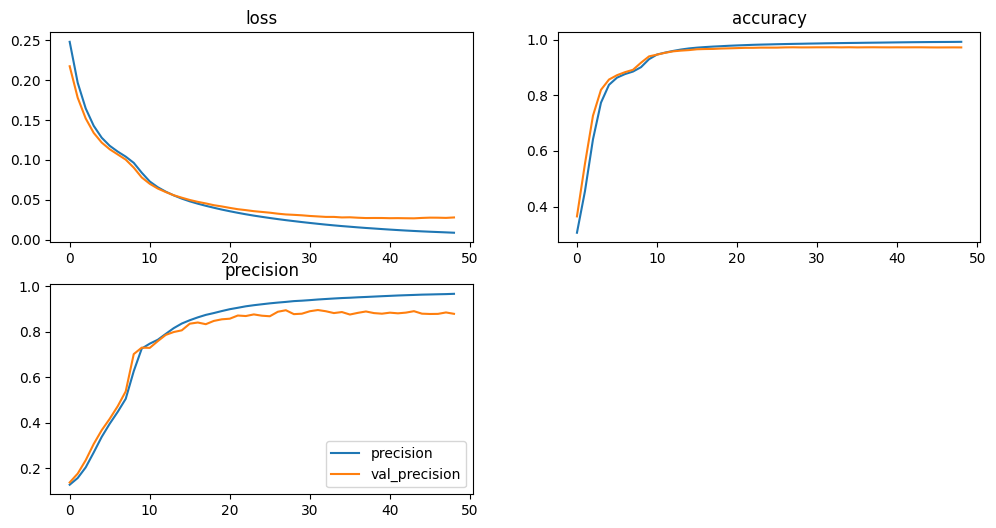

In [ ]:
metrics = ['loss','accuracy', 'precision']
plt.figure(figsize = (12, 6))
for i in range(3):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [ ]:
G.save_weights('/content/drive/MyDrive/ToothGan/ToothGanFinal/mask_gen_w_f.h5')

In [ ]:
def draw(images, masks, y_pred):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(120):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n], cmap = 'gray')
      plt.title('Input Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(np.reshape(y_pred[n], (224, 224)), alpha = 0.6, cmap = 'gray')
      plt.title('Predicted Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [ ]:
G = tf.keras.models.load_model('/content/drive/MyDrive/ToothGan/ToothGanFinal/mask_gen_f.h5')

In [ ]:
G.evaluate(validImages, validMasks)


4/4 [==============================] - 8s 409ms/step - loss: 0.0266 - accuracy: 0.9726 - precision: 0.8910 - recall: 0.8629


[0.026627592742443085,
 0.9725777506828308,
 0.8910287022590637,
 0.8628993034362793]

In [ ]:
G.evaluate(trainImages, trainMasks)


16/16 [==============================] - 7s 444ms/step - loss: 0.0104 - accuracy: 0.9916 - precision: 0.9683 - recall: 0.9582


[0.010438622906804085,
 0.9915648698806763,
 0.9683107137680054,
 0.958183765411377]

In [ ]:
masks_pred = G.predict(trainImages)
masks_pred = (masks_pred >= 0.5).astype('int')

16/16 [==============================] - 7s 462ms/step


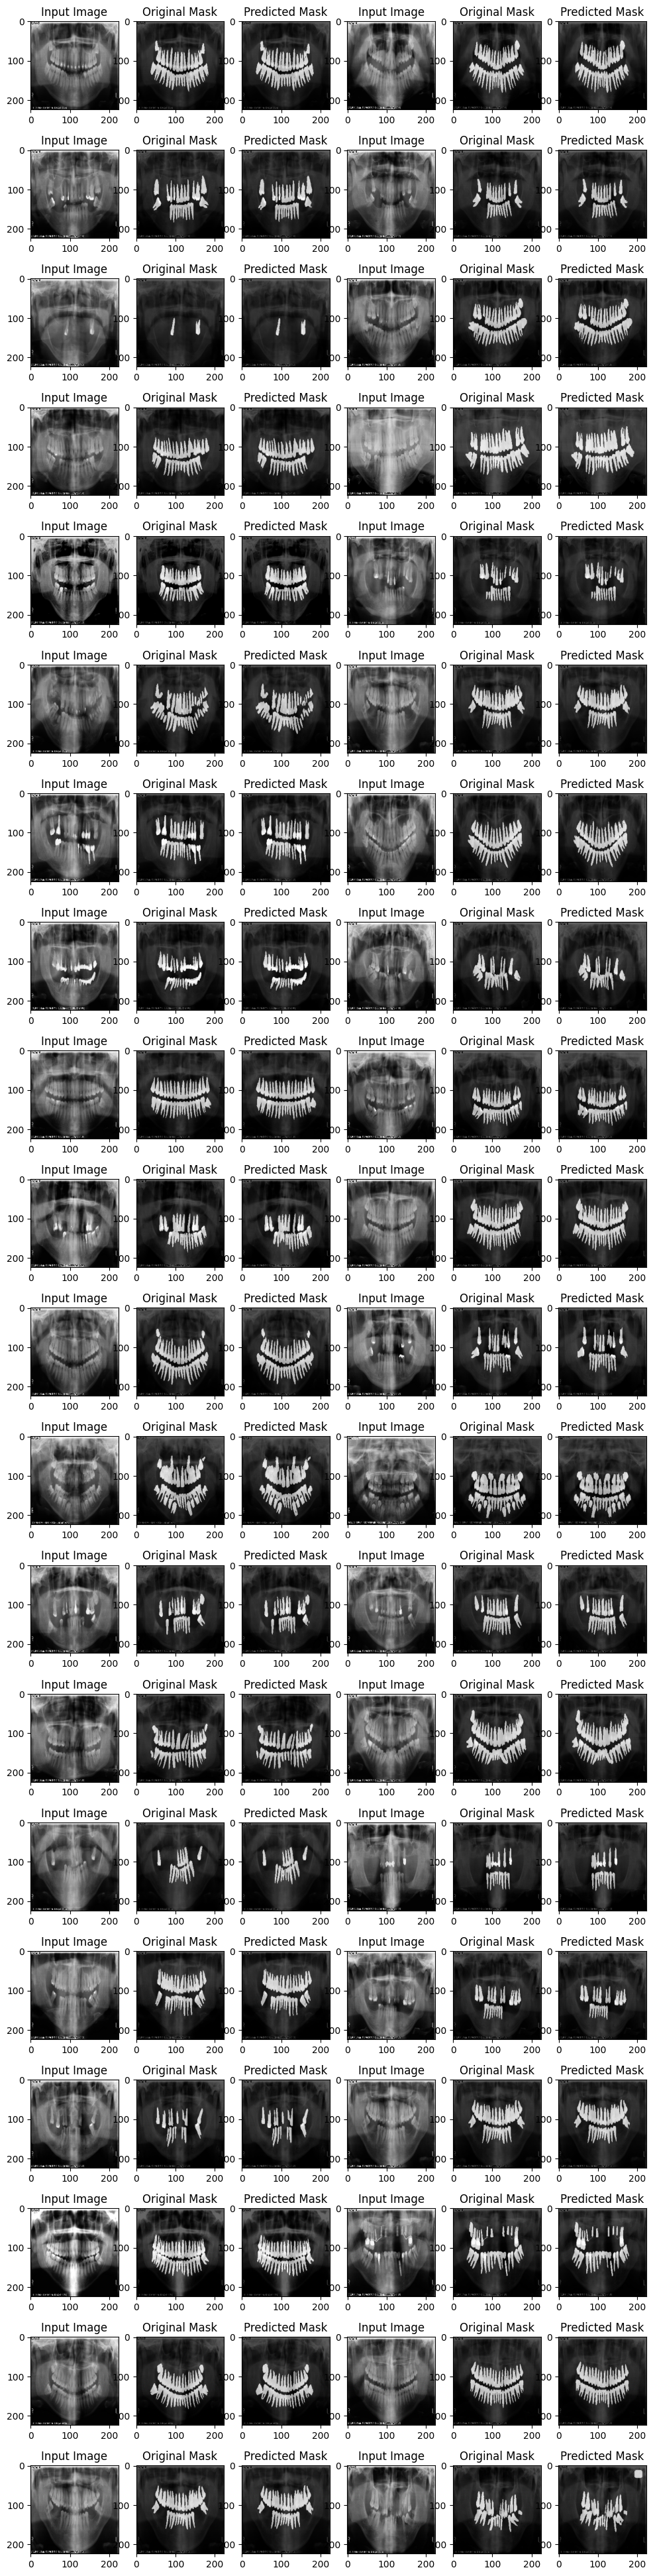

In [ ]:
draw(trainImages, trainMasks, masks_pred)
